# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Вструпление

Заказчик этого исследования — сеть отелей «Как в гостях».
<br>
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
<br>
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Шаг 1. Откройте файлы с данными

Импортируем библиотеки

In [310]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

Сохраним оба файла с данными в отдельные датафреймы

In [311]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

Напишем функцию, которая позволит посмотреть общие данные о файлах

In [312]:
def analyze_dataset(data, name):
    print(name, 'состоит из: ', data.shape[0], 'строк и ', data.shape[1], 'столбцов\nКоличество дубликатов:', data.duplicated().sum())
    print()
    print(data.info())
    print()
    display(data.describe(include='all').transpose())
    print()
    display(data.head(10))
    print()
    data.hist(figsize=(20, 20), bins = 50, color='black');
    plt.show()
    corr = data.corr().round(2)
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, annot=True, square = True)
    plt.show()

<div class="alert alert-info">
<b>v.1:</b> готово
<bv>
<br>
Удалим столбец <b>id</b> и воспользуемся функцией
</div>

In [313]:
hotel_train = hotel_train.drop('id', axis = 1)
hotel_test = hotel_test.drop('id', axis = 1)

Посмотрим данные первого датафрейма: <b>hotel_train</b>

hotel tain состоит из:  65229 строк и  24 столбцов
Количество дубликатов: 21377

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  object 
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal        

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_canceled,65229.0,NaN,NaN,NaN,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,NaN,NaN,NaN,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,NaN,NaN,NaN,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_month,65229,12,October,9255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,65229.0,NaN,NaN,NaN,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,NaN,NaN,NaN,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,NaN,NaN,NaN,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,NaN,NaN,NaN,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,NaN,NaN,NaN,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,NaN,NaN,NaN,0.07489,0.334243,0.0,0.0,0.0,0.0,3.0


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,...,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,...,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,3
5,1,75.0,2015,July,27,1,0,3,2.0,0.0,...,0,0,0,D,0,0,Transient,0,0,3
6,1,23.0,2015,July,27,1,0,4,2.0,0.0,...,0,0,0,E,0,0,Transient,0,0,4
7,0,18.0,2015,July,27,1,0,4,2.0,1.0,...,0,0,0,G,1,0,Transient,0,1,4
8,0,68.0,2015,July,27,1,0,4,2.0,0.0,...,0,0,0,D,0,0,Transient,0,3,4
9,0,37.0,2015,July,27,1,0,4,2.0,0.0,...,0,0,0,E,0,0,Contract,0,0,4


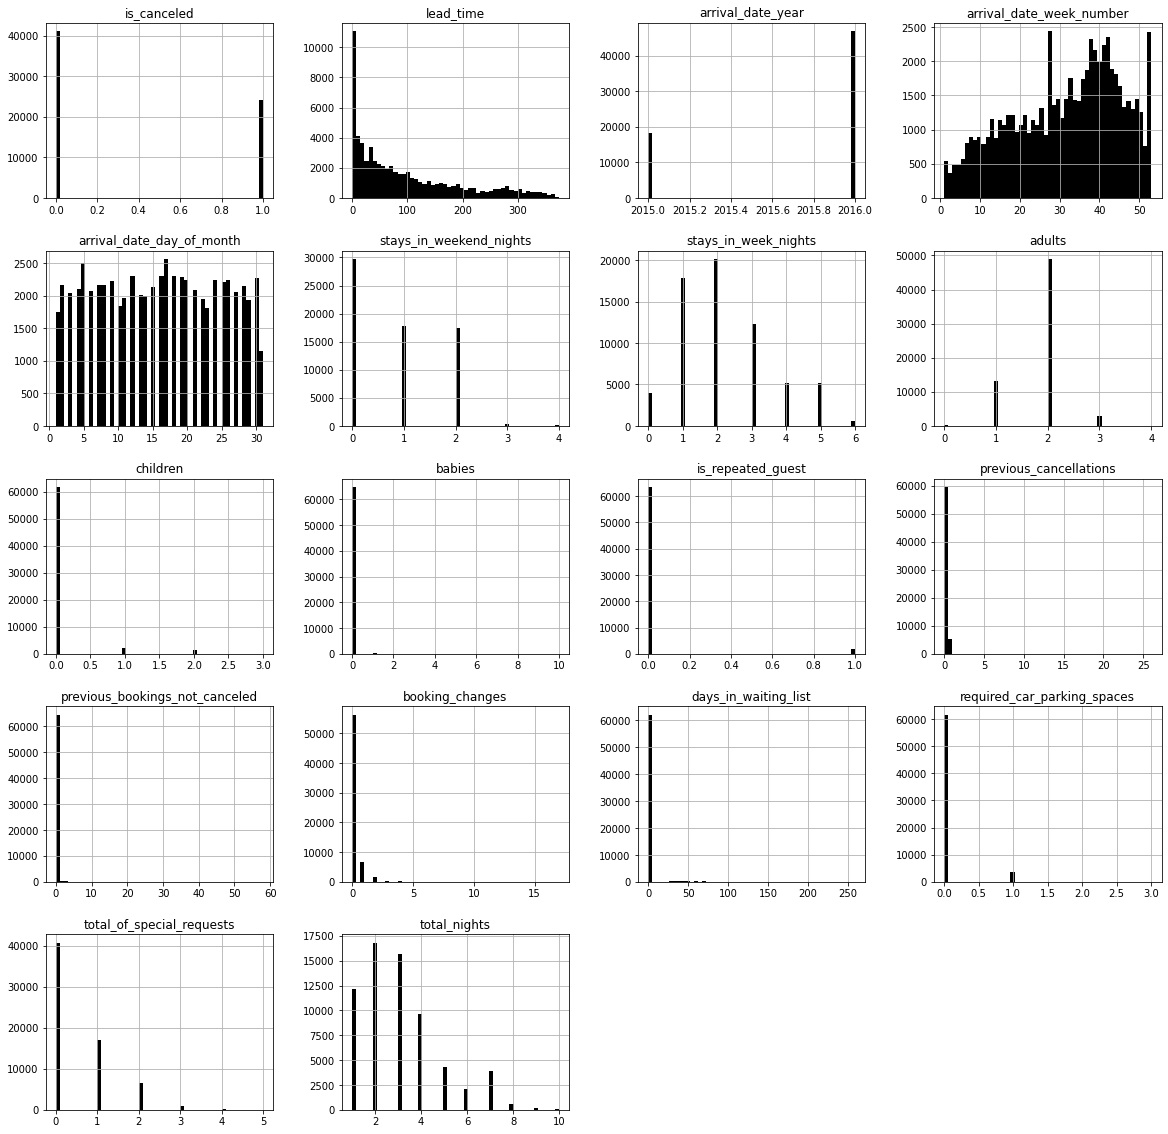

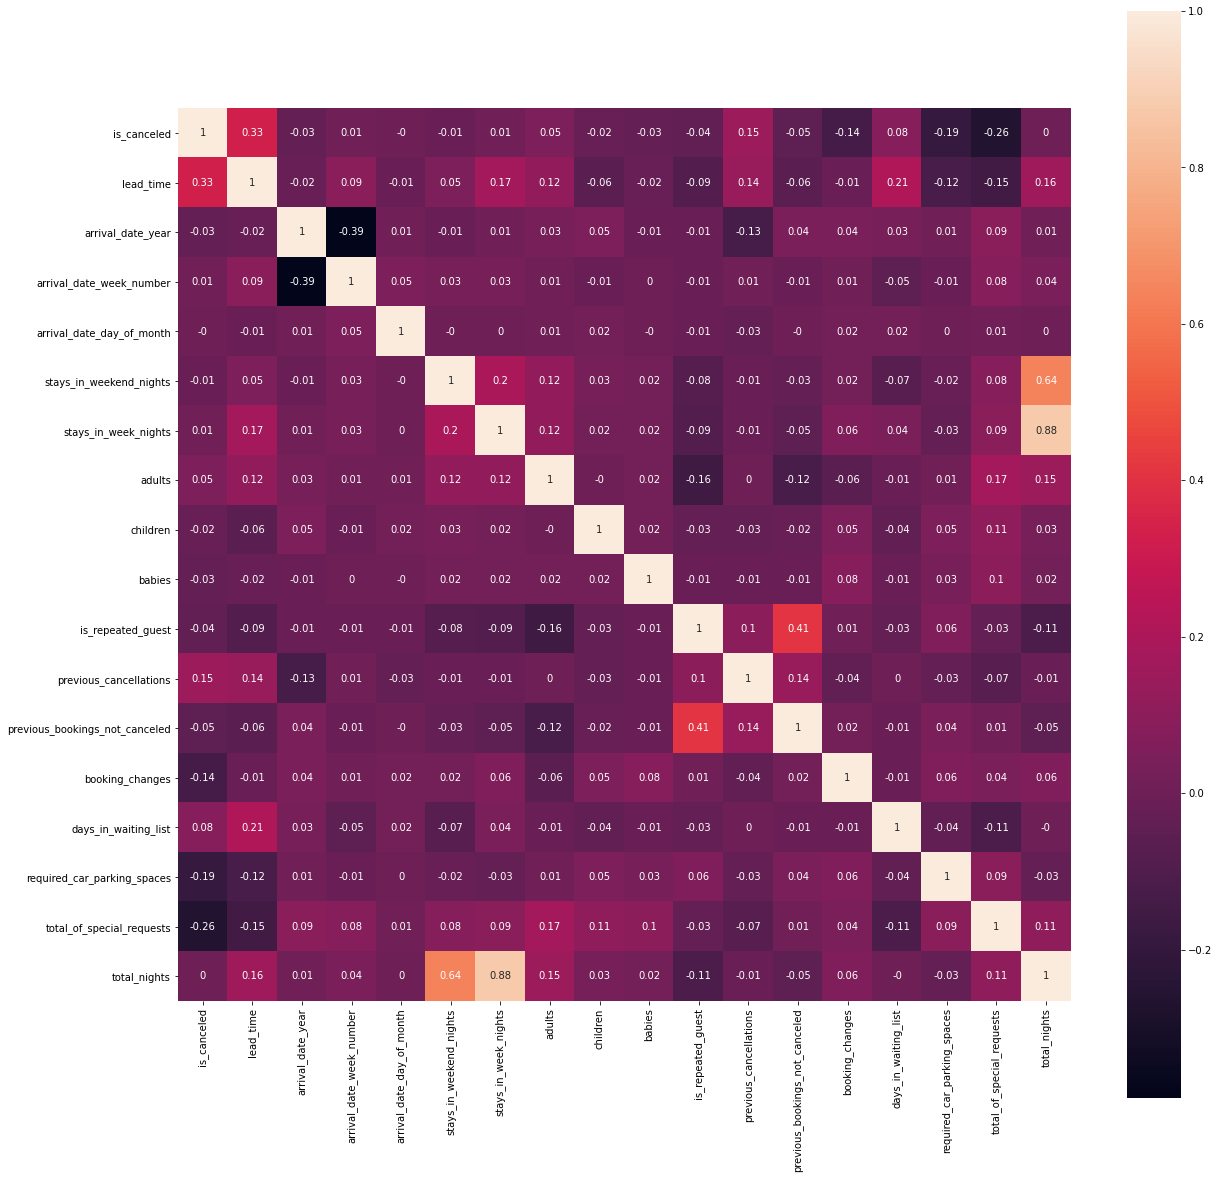

In [314]:
analyze_dataset(hotel_train, "hotel tain")

Посмотрим данные второго датафрейма: <b>hotel_test</b>

hotel test состоит из:  32412 строк и  24 столбцов
Количество дубликатов: 7717

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32412 non-null  int64  
 1   lead_time                       32412 non-null  float64
 2   arrival_date_year               32412 non-null  int64  
 3   arrival_date_month              32412 non-null  object 
 4   arrival_date_week_number        32412 non-null  int64  
 5   arrival_date_day_of_month       32412 non-null  int64  
 6   stays_in_weekend_nights         32412 non-null  int64  
 7   stays_in_week_nights            32412 non-null  int64  
 8   adults                          32412 non-null  float64
 9   children                        32412 non-null  float64
 10  babies                          32412 non-null  float64
 11  meal         

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_canceled,32412.0,NaN,NaN,NaN,0.388467,0.487409,0.0,0.0,0.0,1.0,1.0
lead_time,32412.0,NaN,NaN,NaN,97.587869,86.507146,0.0,23.0,76.0,155.0,373.0
arrival_date_year,32412.0,NaN,NaN,NaN,2017.0,0.0,2017.0,2017.0,2017.0,2017.0,2017.0
arrival_date_month,32412,8,May,5262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,32412.0,NaN,NaN,NaN,17.804054,9.177384,1.0,10.0,18.0,25.0,35.0
arrival_date_day_of_month,32412.0,NaN,NaN,NaN,15.656948,8.766429,1.0,8.0,15.5,23.0,31.0
stays_in_weekend_nights,32412.0,NaN,NaN,NaN,0.867888,0.853394,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,32412.0,NaN,NaN,NaN,2.34009,1.37517,0.0,1.0,2.0,3.0,6.0
adults,32412.0,NaN,NaN,NaN,1.858602,0.489341,0.0,2.0,2.0,2.0,4.0
children,32412.0,NaN,NaN,NaN,0.083765,0.34347,0.0,0.0,0.0,0.0,3.0


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
2,1,62.0,2017,January,1,1,2,2,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
4,1,172.0,2017,January,1,1,2,5,2.0,0.0,...,0,0,0,A,0,0,Transient,0,0,7
5,1,52.0,2017,January,1,1,2,5,1.0,0.0,...,0,0,0,A,0,0,Transient,0,0,7
6,1,143.0,2017,January,1,2,1,1,2.0,0.0,...,0,0,0,A,1,0,Transient,0,1,2
7,1,21.0,2017,January,1,2,1,3,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
8,1,89.0,2017,January,1,2,1,3,2.0,0.0,...,0,0,0,E,0,0,Transient,0,0,4
9,1,48.0,2017,January,1,2,1,4,2.0,0.0,...,0,0,0,A,1,0,Transient,0,2,5


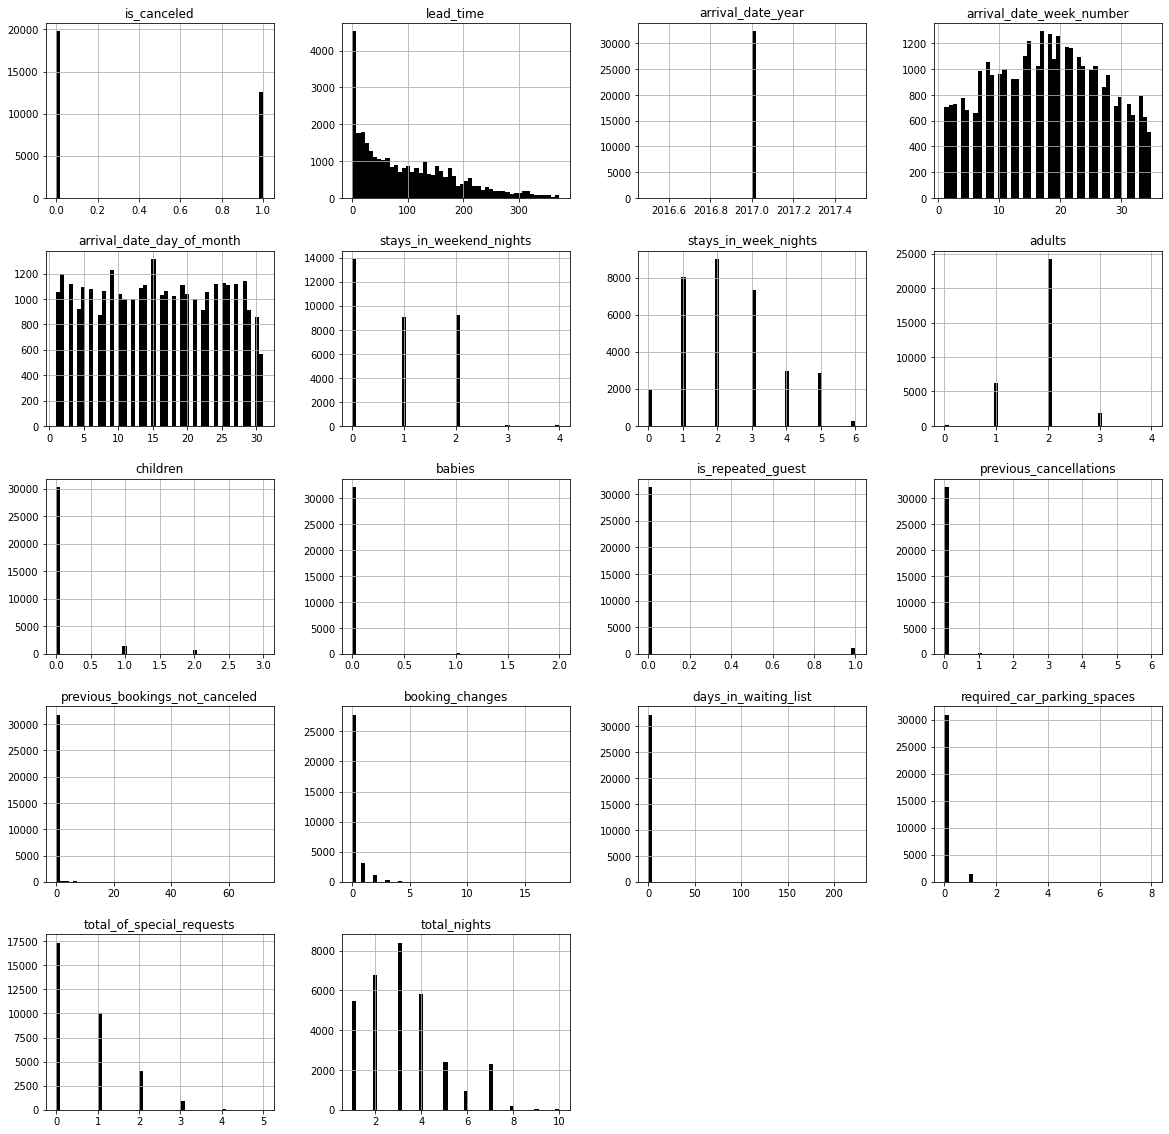

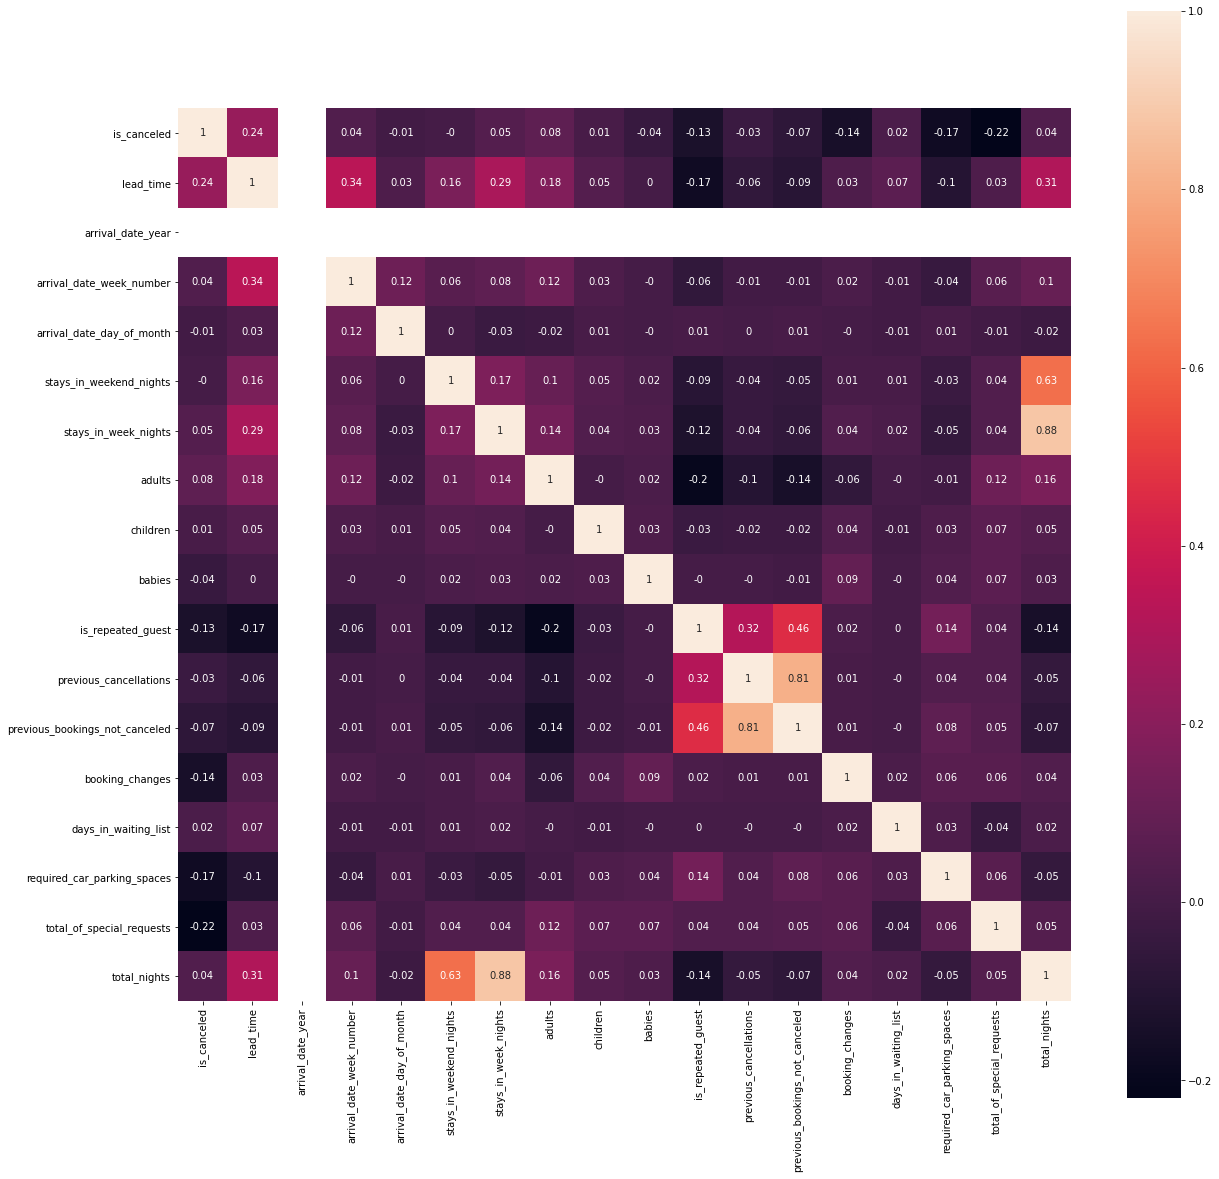

In [315]:
analyze_dataset(hotel_test, "hotel test")

<div class="alert alert-info">
<b>ВЫВОД update v.1:</b>
<bv>
<br>
После удаления столбца <b>id</b> обнаружилось <b>21377</b> дубликатов в датафрейме <b>hotel_train</b> и <b>7717</b> дубликатов в датафрейме <b>hotel_test</b>
<br>
удалим эти дубликаты.
</div>

In [316]:
hotel_train.drop_duplicates(inplace = True, ignore_index = True)
hotel_test.drop_duplicates(inplace = True, ignore_index = True)

<b>ВЫВОД:</b>
<br>
Целевой признак - <b>is_canceled</b>
<br>
Есть колонки с формати float, int и текст. Однако, мы видим, что есть колонки, которые явно должны отображать информацию в формате int (такие как adults, children, babies), но в настоящее время они в формате float
<br>
<br>
Как мы видим явных дубликатов в датасетах нет, но мы также видим, что есть столбец, который называется "meal" и там должно быть 4 варианта (категориальные значения), но в полученных данных указано 5 уникальных элементов
<br>
<br>
В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
<br>
<br>
<b>id</b> — номер записи;
<br>
<b>adults</b> — количество взрослых постояльцев;
<br>
<b>arrival_date_year</b> — год заезда;
<br>
<b>arrival_date_month</b> — месяц заезда;
<br>
<b>arrival_date_week_number</b> — неделя заезда;
<br>
<b>arrival_date_day_of_month</b> — день заезда;
<br>
<b>babies</b> — количество младенцев;
<br>
<b>booking_changes</b> — количество изменений параметров заказа;
<br>
<b>children</b> — количество детей от 3 до 14 лет;
<br>
<b>country</b> — гражданство постояльца;
<br>
<b>customer_type</b> — тип заказчика:
<br>
<b>Contract</b> — договор с юридическим лицом;
<br>
<b>Group</b> — групповой заезд;
<br>
<b>Transient</b> — не связано с договором или групповым заездом;
<br>
<b>Transient-party</b> — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
<br>
<b>days_in_waiting_list</b> — сколько дней заказ ожидал подтверждения;
<br>
<b>distribution_channel</b> — канал дистрибуции заказа;
<br>
<b>is_canceled</b> — отмена заказа;
<br>
<b>is_repeated_guest</b> — признак того, что гость бронирует номер второй раз;
<br>
<b>lead_time</b> — количество дней между датой бронирования и датой прибытия;
<br>
<b>meal</b> — опции заказа:
<br>
<b>SC</b> — нет дополнительных опций;
<br>
<b>BB</b> — включён завтрак;
<br>
<b>HB</b> — включён завтрак и обед;
<br>
<b>FB</b> — включён завтрак, обед и ужин.
<br>
<b>previous_bookings_not_canceled</b> — количество подтверждённых заказов у клиента;
<br>
<b>previous_cancellations</b> — количество отменённых заказов у клиента;
<br>
<b>required_car_parking_spaces</b> — необходимость места для автомобиля;
<br>
<b>reserved_room_type</b> — тип забронированной комнаты;
<br>
<b>stays_in_weekend_nights</b> — количество ночей в выходные дни;
<br>
<b>stays_in_week_nights</b> — количество ночей в будние дни;
<br>
<b>total_nights</b> — общее количество ночей;
<br>
<b>total_of_special_requests</b> — количество специальных отметок.

<strike>Сразу избавимся от столбцов <b>id</b> в обоих датафреймах</strike>

In [317]:
#hotel_train.drop(columns='id', inplace = True)
#hotel_test.drop(columns='id', inplace = True)

### Шаг 2. Предобработка и исследовательский анализ данных

Проверим отдельно столбец <b>meal</b> т.к. согласно условию должно быть 4 уникальных элемента, а не 5
<br>
Для этого посчитаем количество повторений уникальных значений сначала для <b>hotel_train</b>, а затем для <b>hotel_test</b> и построим графики для наглядности
<br>
<br>
p.s. вернулся к этому шагу. есть подозрения, что в других колонках может происходить такая же хрень. поэтому напишу функцию, которой можно будет палить все такие кейсы

In [318]:
def show_me_stuff(train_df, test_df, column_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    train_counts = train_df[column_name].value_counts()
    train_counts.plot(kind='bar', ax=axes[0], color='black')
    axes[0].set_title('hotel_train')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Количество')
    for i, v in enumerate(train_counts):
        axes[0].text(i, v + 10, str(v), ha='center', color='black', fontweight='bold')

    test_counts = test_df[column_name].value_counts()
    test_counts.plot(kind='bar', ax=axes[1], color='black')
    axes[1].set_title('hotel_test')
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel('Количество')
    for i, v in enumerate(test_counts):
        axes[1].text(i, v + 10, str(v), ha='center', color='black', fontweight='bold')

    plt.subplots_adjust(wspace=1)

    plt.show()

Для начала проверим столбец <b>meal</b> в обоих датафреймах

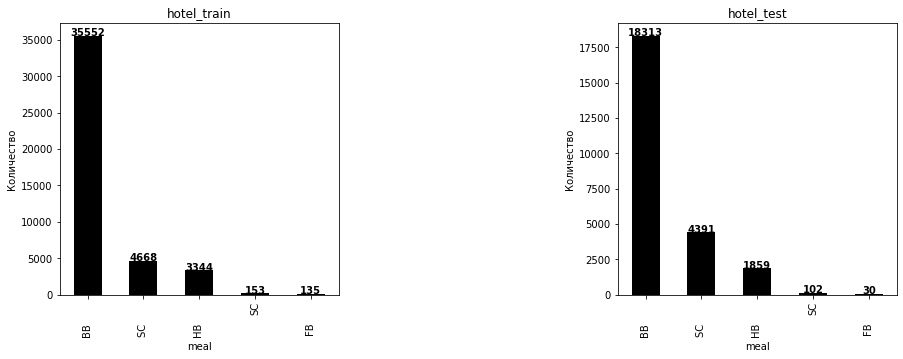

In [319]:
show_me_stuff(hotel_train, hotel_test, 'meal')

Как видно на графиках - среди категориальных значений есть значения с пробелами, которые выделяются в неявные дубликаты.
<br>
Уберем эти пробелы и посмотрим на эти графики еще раз

In [320]:
hotel_test['meal'] = hotel_test['meal'].str.strip()
hotel_train['meal'] = hotel_train['meal'].str.strip()

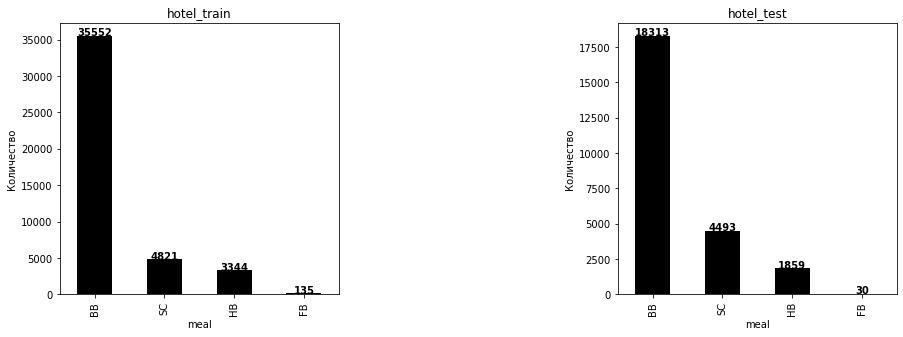

In [321]:
show_me_stuff(hotel_train, hotel_test, 'meal')

Другое дело! и удобно, что можно делать все одной функцией. теперь проверим другие столбцы этим же способом

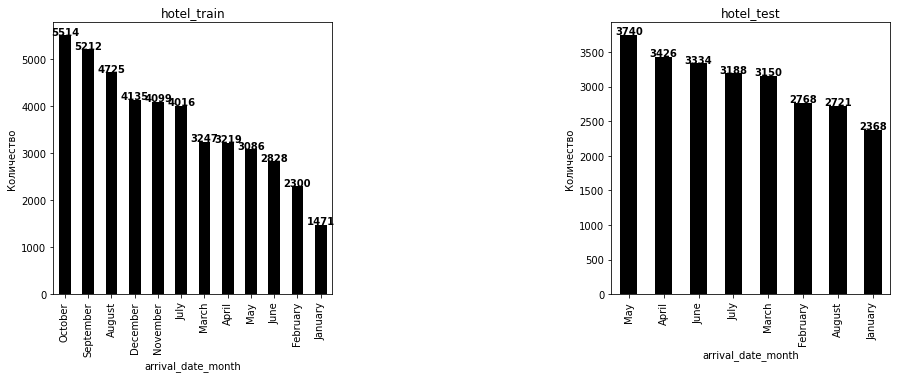

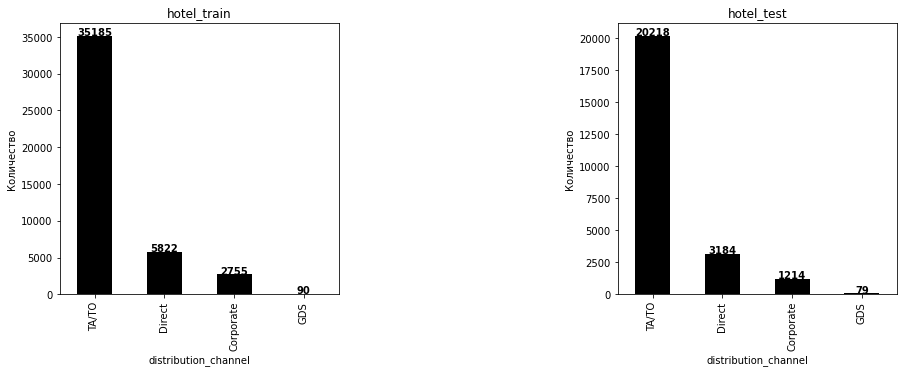

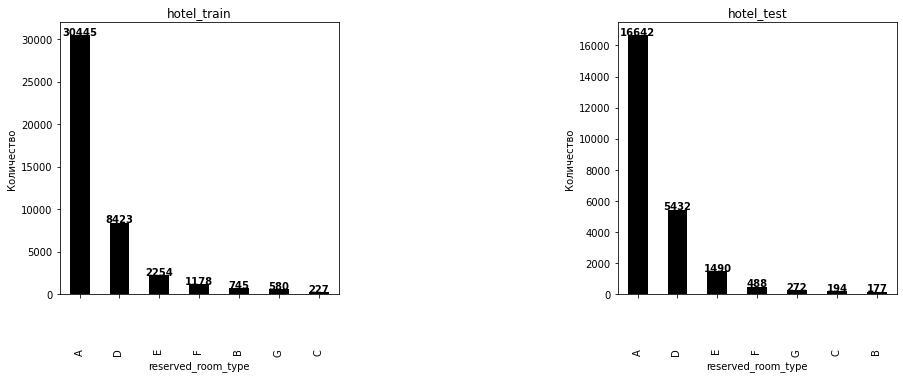

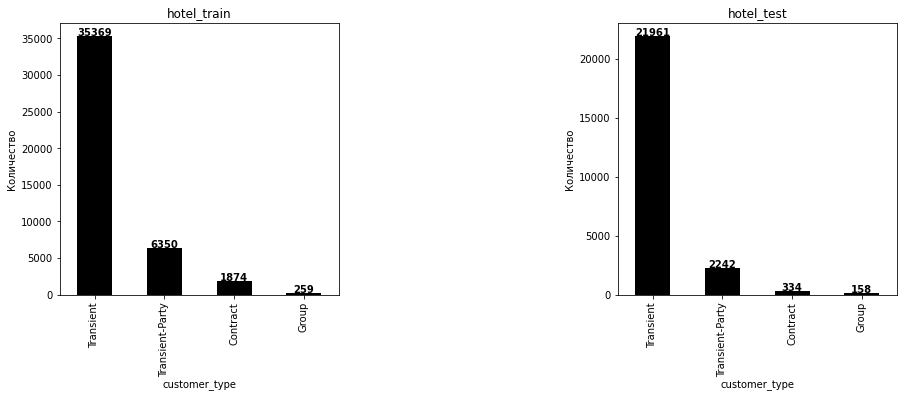

In [322]:
columns = ['arrival_date_month', 'distribution_channel', 'reserved_room_type', 'customer_type']
for col in columns:
    show_me_stuff(hotel_train, hotel_test, col)

В колонке <b>reserved_room_type</b> в названиях категориальных значений есть пробелы, не знаю ошибка это или нет, но на всякий тоже уберем там пробелы

In [323]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

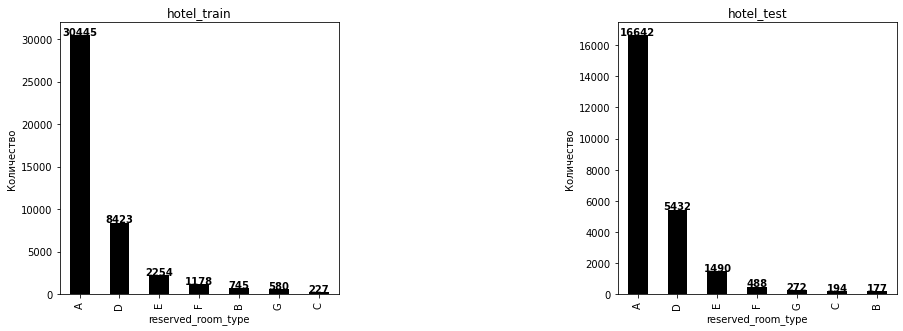

In [324]:
show_me_stuff(hotel_train, hotel_test, 'reserved_room_type')

Теперь преобразуем колонки float в int (adults, children, babies)

In [325]:
columns = ['adults', 'children', 'babies']
tables = [hotel_test, hotel_train]
for table in tables:
    for col in columns:
        table[col] = table[col].astype('int64')

Теперь внимательно посмотрим на целевой признак - <b>is_canceled</b>

In [326]:
def display_target_features(hotel_train, hotel_test):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    
    ax1 = axes[0, 0]
    sns.countplot(hotel_train['is_canceled'], ax=ax1)
    ax1.set_xlabel('is_canceled', fontsize=12)
    ax1.set_ylabel('Количество', fontsize=12)
    ax1.set_title('hotel_train', fontsize=14)
    
    ax2 = axes[0, 1]
    sns.countplot(hotel_test['is_canceled'], ax=ax2)
    ax2.set_xlabel('is_canceled', fontsize=12)
    ax2.set_ylabel('Количество', fontsize=12)
    ax2.set_title('hotel_test', fontsize=14)
    
    ax3 = axes[1, 0]
    sns.histplot(hotel_train['is_canceled'], ax=ax3, kde=True)
    ax3.set_xlabel('is_canceled', fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_title('hotel_train', fontsize=14)
    
    ax4 = axes[1, 1]
    sns.histplot(hotel_test['is_canceled'], ax=ax4, kde=True)
    ax4.set_xlabel('is_canceled', fontsize=12)
    ax4.set_ylabel('Количество', fontsize=12)
    ax4.set_title('hotel_test', fontsize=14)
    
    ax5 = axes[2, 0]
    vc_train = hotel_train['is_canceled'].value_counts()
    ax5.pie(vc_train, labels=vc_train.index, autopct='%1.1f%%', startangle=90)
    ax5.axis('equal')
    ax5.set_title('hotel_train', fontsize=14)
    
    ax6 = axes[2, 1]
    vc_test = hotel_test['is_canceled'].value_counts()
    ax6.pie(vc_test, labels=vc_test.index, autopct='%1.1f%%', startangle=90)
    ax6.axis('equal')
    ax6.set_title('hotel_test', fontsize=14)
    
    plt.tight_layout()
    plt.show()

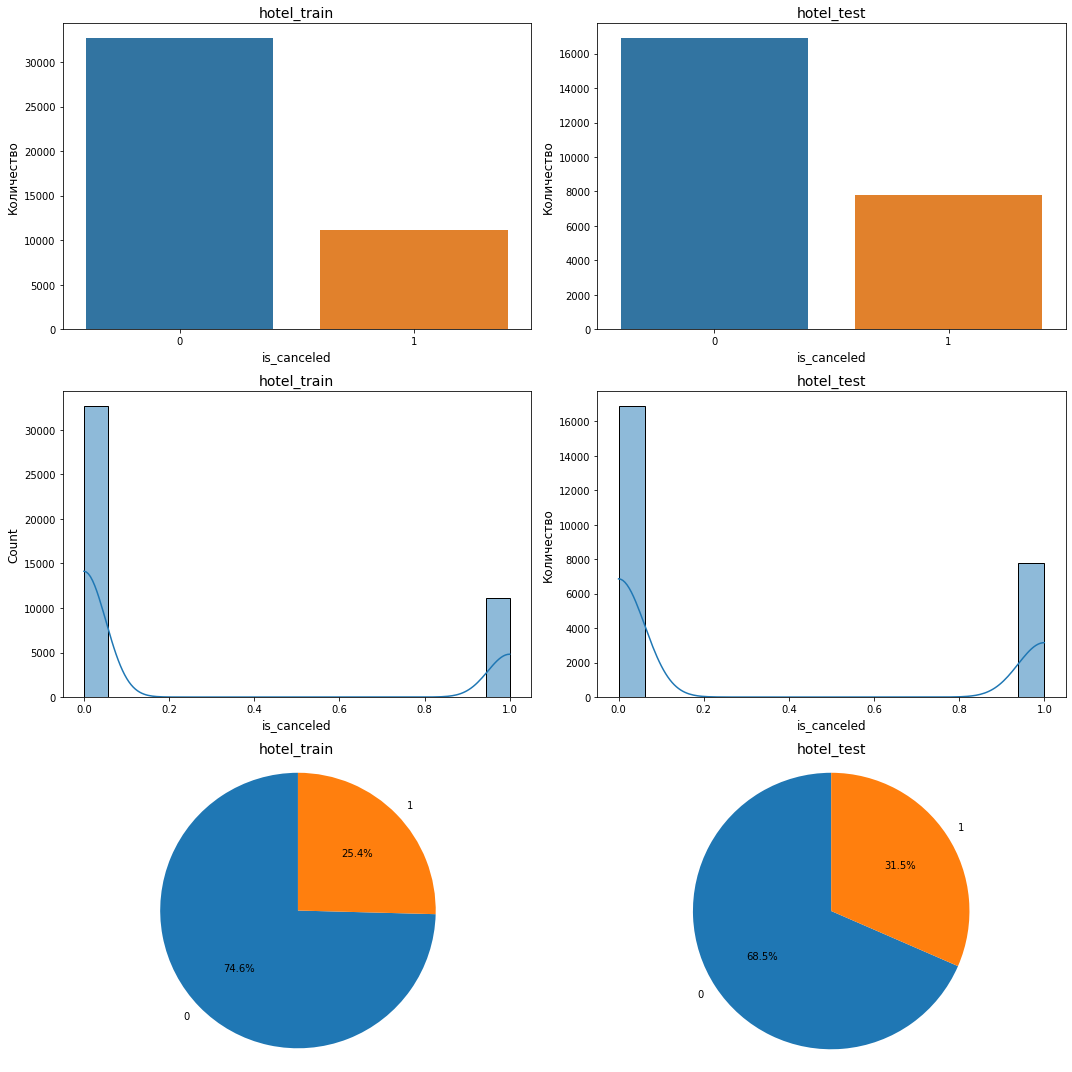

In [327]:
display_target_features(hotel_train, hotel_test)

Теперь нужно посмотреть на корреляцию целевого признака со всеми остальными признаками, для этого напишем небольшую функцию

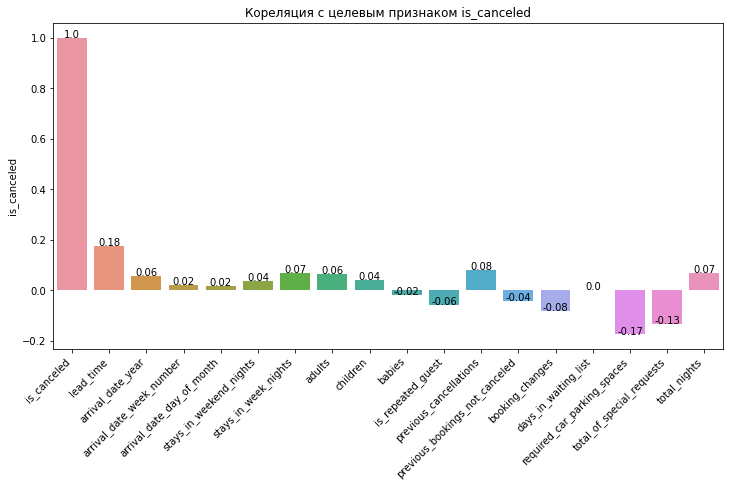

posx and posy should be finite values
posx and posy should be finite values


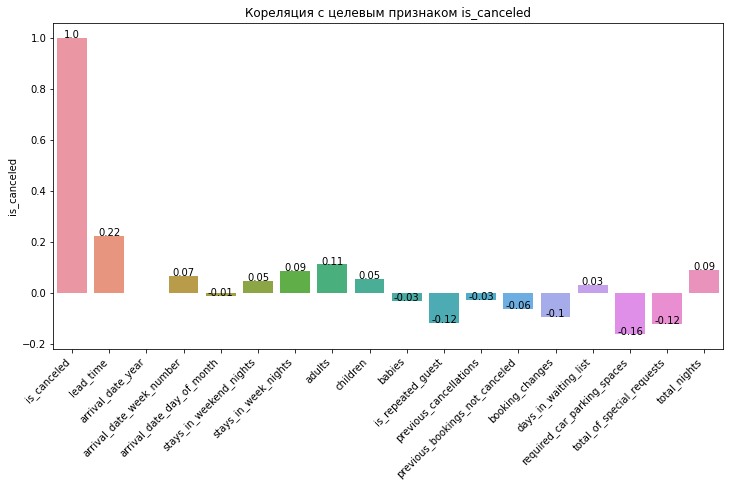

In [328]:
df_list = [hotel_train, hotel_test]

for df in df_list:
    corr_matrix = df.corr()

    # extract the correlations with is_canceled
    corr_with_target = corr_matrix['is_canceled']

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=corr_with_target.index, y=corr_with_target)
    plt.xticks(rotation=45, ha='right')
    plt.title('Кореляция с целевым признаком is_canceled')
    for i, v in enumerate(corr_with_target):
        ax.text(i, v, f"{round(v, 2)}", color='black', ha='center')
    plt.show()

<div class="alert alert-info">
<b>Посмотрим на выбросы в других столбцах v.1:</b>
</div>

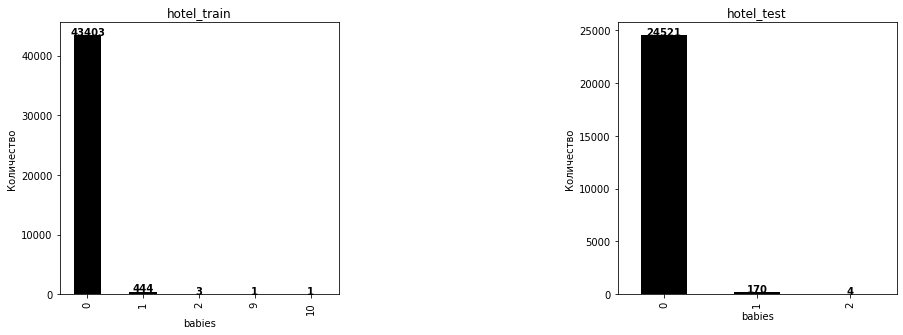

In [329]:
show_me_stuff(hotel_train, hotel_test, 'babies')

в hotel_train удалим записи выше 2. 9+ детей это как-то жестко

In [330]:
hotel_train['has_babies'] = (hotel_train['babies'] > 0).astype(int)
hotel_train = hotel_train[hotel_train['babies'] <= 1]
hotel_test['has_babies'] = (hotel_test['babies'] > 0).astype(int)
hotel_test = hotel_test[hotel_test['babies'] <= 1]
hotel_train = hotel_train.drop('babies', axis = 1)
hotel_test = hotel_test.drop('babies', axis = 1)

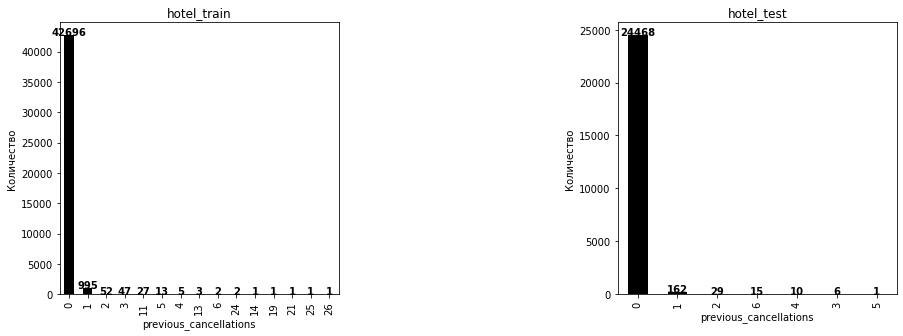

In [331]:
show_me_stuff(hotel_train, hotel_test, 'previous_cancellations')

можно удалить все, что выше 10

In [332]:
hotel_train.drop(hotel_train[hotel_train['previous_cancellations'] > 5].index, inplace=True)
hotel_test.drop(hotel_test[hotel_test['previous_cancellations'] > 5].index, inplace=True)

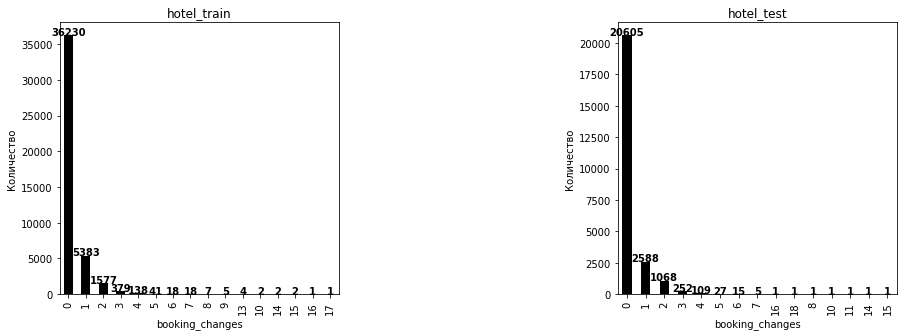

In [333]:
show_me_stuff(hotel_train, hotel_test, 'booking_changes')

тут тоже удалим все, что выше 10

In [334]:
hotel_train.drop(hotel_train[hotel_train['booking_changes'] > 5].index, inplace=True)
hotel_test.drop(hotel_test[hotel_test['booking_changes'] > 5].index, inplace=True)

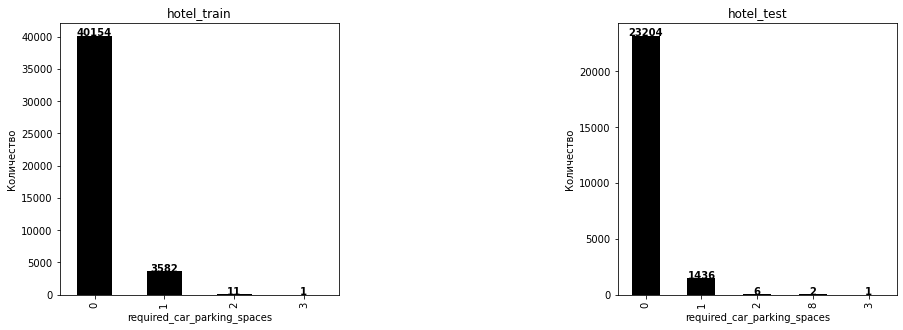

In [335]:
show_me_stuff(hotel_train, hotel_test, 'required_car_parking_spaces')

тут уберем все, что выше 1

In [336]:
hotel_train.drop(hotel_train[hotel_train['required_car_parking_spaces'] > 1].index, inplace=True)
hotel_test.drop(hotel_test[hotel_test['required_car_parking_spaces'] > 1].index, inplace=True)

Уберем случаи, когда есть только дети без взрослых и удалим их

In [337]:
hotel_train.query('(children > 0 | has_babies > 0) & adults == 0').shape[0]

148

In [338]:
hotel_train.drop(hotel_train.query('(children > 0 | has_babies > 0) & adults == 0').index, inplace=True)

In [339]:
hotel_test.query('(children > 0 | has_babies > 0) & adults == 0').shape[0]

58

In [340]:
hotel_test.drop(hotel_train.query('(children > 0 | has_babies > 0) & adults == 0').index, inplace=True)

Уберем случаи, когда нет взрослых

In [341]:
hotel_train.query('adults == 0').shape[0]

15

In [342]:
hotel_train.drop(hotel_train.query('adults == 0').index, inplace=True)

In [343]:
hotel_test.query('adults == 0').shape[0]

65

In [344]:
hotel_test.drop(hotel_test.query('adults == 0').index, inplace=True)

Судя по описанию, total_nights — это сумма stays_in_week_nights и stays_in_weekend_nights. Можно это проверить, но если это и правда так, то все три признака нам точно не нужны

In [345]:
(hotel_train['stays_in_week_nights'] + hotel_train['stays_in_weekend_nights']).equals(hotel_train['total_nights'])


True

Вывод: столбец total_nights действительно является суммой двух других столбцов

In [346]:
hotel_train = hotel_train.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1)
hotel_test = hotel_test.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1)

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
<br>
<br>
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь.
Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
<br>
<br>
Стоимость номеров отеля:
<br>
<li>
категория A: за ночь — 1 000, разовое обслуживание — 400;
<li>
категория B: за ночь — 800, разовое обслуживание — 350;
<li>
категория C: за ночь — 600, разовое обслуживание — 350;
<li>
категория D: за ночь — 550, разовое обслуживание — 150;
<li>
категория E: за ночь — 500, разовое обслуживание — 150;
<li>
категория F: за ночь — 450, разовое обслуживание — 150;
<li>
категория G: за ночь — 350, разовое обслуживание — 150.
</li>
<br>
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
<br>
<br>
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
<br>
<br>
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.
<br>
<br>
Для оценки прибыли отеля без внедрения депозитов, необходимо рассчитать общую стоимость всех забронированных номеров за весь период, вычесть из этой суммы затраты на обслуживание гостей и полученную сумму умножить на сезонный коэффициент.
<br>
<br>
Для этого, нужно рассчитать стоимость проживания каждого гостя в отеле на основе информации о типе номера, количестве ночей и количестве гостей.
<br>
<br>
Чтобы учесть сезонные колебания, необходимо умножить на соответствующий коэффициент.

Создадим функцию, которая посчитает прибыль отделя без ведения депозитов

Сначала сделаем пару справочников
<br>
Сначала для цен

In [347]:
room_columns = ['reserved_room_type' , 'room_price', 'cleaning_service']
room_data = pd.DataFrame(data=[
    ['A', 1000, 400],
    ['B', 800, 350],
    ['C', 600, 350],
    ['D', 550, 150], 
    ['E', 500, 150],
    ['F', 450, 150],
    ['G', 350, 150]
], columns=room_columns)

Теперь для определения коэф.сезона (умножать на 1.2 или 1.4 или оставить как есть)

In [348]:
summer = ['June', 'July', 'August']
winter = ['December', 'January', 'February']

Теперь напишем функцию, которая будет использовать справочники для определения прибыли отеля без ведения депозитов

<div class="alert alert-info">
<b>Update функции v.2:</b>
</div>

In [351]:
def count_revenue(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    total_nights = row['total_nights']
    
    price = room_data.loc[room_data['reserved_room_type'] == room_type, 'room_price'].iloc[0]
    prepare_cost = room_data.loc[room_data['reserved_room_type'] == room_type, 'cleaning_service'].iloc[0]
    
    prepare_nights = 1 + (total_nights - 1) // 2
    
    if row['is_canceled'] == 0:
        if month in summer:
            revenue = 1.4 * price * total_nights - prepare_cost * prepare_nights
        elif month in winter:
            revenue = price * total_nights - prepare_cost * prepare_nights
        else:
            revenue = 1.2 * price * total_nights - prepare_cost * prepare_nights
    else:
        revenue = - (prepare_cost + price) * 1.4 if month in summer else - (prepare_cost + price)
    
    return revenue

Посчитаем прибыль

In [352]:
total_revenue = hotel_test.apply(count_revenue, axis=1).sum()
print('Прибыль отеля без ведения депозита:', total_revenue)

Прибыль отеля без ведения депозита: 34793290.0


### Шаг 4. Разработка модели ML

<li>Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.
<li>Выберите метрику для обучения.
<li>Оцените прибыль, которую принесёт выбранная модель за год.

Когда мы обучаем модели, мы должны выбрать признаки и целевой признак. Мы сформулировали задачу для модели как задачу классификации: определить, будет ли бронирование отменено или нет. Поэтому целевым признаком является столбец <b>is_canceled</b></b>
<br>
<br>
Мы будем использовать следующие столбцы в качестве признаков, которые, на наш взгляд, могут повлиять на принятие решения об отмене бронирования: 
<br>
<b>adults</b>,
<br>
<b>arrival_date_week_number</b>,
<br>
<strike><b>babies</b></strike>,
<br>
<b>has_babies</b>,
<br>
<b>country</b>,
<br>
<b>children</b>,
<br>
<b>customer_type</b>,
<br>
<b>days_in_waiting_list</b>,
<br>
<b>is_repeated_guest</b>,
<br>
<b>lead_time</b>,
<br>
<b>meal</b>,
<br>
<b>previous_bookings_not_canceled</b>,
<br>
<b>previous_cancellations</b>,
<br>
<b>required_car_parking_spaces</b>,
<br>
<b>reserved_room_type</b>,
<br>
<strike><b>stays_in_weekend_nights</b></strike>,
<br>
<strike><b>stays_in_week_nights</b></strike>,
<br>
<b>total_nights</b>
<br>
<b>total_of_special_requests</b>
<br>
<b>booking_changes</b>
<br>
<br>
Чтобы преобразовать категориальные признаки в количественные, мы создадим переменные <b>hotel_train_ohe</b> и <b>hotel_test_ohe</b> и используем OneHotEncoder из библиотеки sklearn.preprocessing.

<div class="alert alert-info">
Мы не используем столбцы
<br>
<br>
id — номер записи - это просто ключ или порядковый номер записи и не влияет на данные
<br>
arrival_date_year — год заезда - у нас есть номер недели
<br>
arrival_date_month — месяц заезда - у нас есть номер недели
<br>
<strike>distribution_channel — канал дистрибуции заказа - мы смотрим на отмену заказа, поэтому неважно откуда клиент</strike>
<br>
stays_in_week_nights — количество ночей в будние дни - выяснили, что есть total_nights
<br>
stays_in_weekend_nights — количество ночей в выходные дни - выяснили, что есть total_nights
</div>

<div class="alert alert-info">
<b>v.2</b>
<br>
babies — количество младенцев. Вместо этого мы используем столбец has_babies, который является бинарным и показывает наличие или отсутствие младенцев.
<br>
booking_changes — количество изменений параметров заказа - может быть полезен как часто клиенты изменяют свои бронирования и как это влияет на отмену заказа.
<br>
distribution_channel — канал дистрибуции заказа - мы смотрим на отмену заказа, поэтому неважно откуда клиент
</div>

In [353]:
selected_columns = ['distribution_channel', 'booking_changes', 'adults', 'arrival_date_week_number', 'has_babies', 'children', 'customer_type', 'country',
                    'days_in_waiting_list', 'is_repeated_guest', 'lead_time', 'meal', 'previous_bookings_not_canceled',
                   'previous_cancellations', 'required_car_parking_spaces', 'reserved_room_type', 'total_nights', 'total_of_special_requests', 'is_canceled']

train_features = hotel_train[selected_columns]
test_features = hotel_test[selected_columns]

train_target = train_features.pop('is_canceled')
test_target = test_features.pop('is_canceled')

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_features)
train_features_encoded = enc.transform(train_features)
test_features_encoded = enc.transform(test_features)

<b>Логистическая регрессия</b>

<div class="alert alert-info">
Основной показатель успешности для любой сети отелей - это прибыль, которая рассчитывается как разница между стоимостью номера на все дни проживания и затратами на его обслуживание, включая подготовку и уборку. В зависимости от типа номера устанавливается цена за каждую ночь, а затраты на уборку возникают каждые два дня, если постояльцы проживают в номере длительное время.
</div>

<div class="alert alert-info">
<b>v.2</b>
<br>
   
мы используем <b>accuracy</b> - это метрика, которая оценивает долю правильно предсказанных классов во общем количестве выборки. она, я так понимаю, полезна, когда у нас в данных все классы важны равнозначно
<br>
<br>
так же мы используем <b>precision</b> - это метрика, которая оценивает долю правильно предсказанных положительных исходов от общего количества положительных исходов. эта метрика полезна, когда бизнесу важно минимизировать количество ложных положительных предсказаний, которые могут повлечь финансовые потери
<br>
<br>
и еще мы смотрим на такую метрику как <b>recall</b> - полнота предсказаний. эта метрика полезна, когда бизнесу важно минимизировать количество ложных отрицательных предсказаний, то есть когда неверно предсказанные отрицательные исходы могут привести к упущенным возможностям или потере потенциальных клиентов
</div>

In [354]:
scoring = ['accuracy', 'precision', 'recall']

In [355]:
logreg = LogisticRegression(random_state = 12345)

param_grid_lg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_search_lg = GridSearchCV(logreg, param_grid_lg, cv=5, scoring = scoring, refit='accuracy')

обучаем модель логистической регрессии на обучающих данных

In [356]:
grid_search_lg.fit(train_features_encoded, train_target)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
             refit='accuracy', scoring=['accuracy', 'precision', 'recall'])

In [357]:
best_lg = grid_search_lg.best_estimator_
best_lg_cv_accuracy = grid_search_lg.best_score_
best_lg_cv_precision = grid_search_lg.cv_results_['mean_test_precision'][grid_search_lg.best_index_]
best_lg_cv_recall = grid_search_lg.cv_results_['mean_test_recall'][grid_search_lg.best_index_]

In [358]:
print('логистическая регрессия : \nAccuracy - ', best_lg_cv_accuracy, '\nPrecision - ', best_lg_cv_precision, '\nRecall - ', best_lg_cv_recall)

логистическая регрессия : 
Accuracy -  0.7463329721390564 
Precision -  0.5053241394765807 
Recall -  0.19518581732092716


<b>Древо решений</b>

определим диапазон значений параметров для подбора

In [359]:
param_grid_clf = {'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

In [360]:
clf = DecisionTreeClassifier(random_state = 12345)

In [361]:
grid_search_clf = GridSearchCV(clf, param_grid_clf, cv=5, scoring = scoring, refit='accuracy')

обучаем модель на обучающих данных

In [362]:
grid_search_clf.fit(train_features_encoded, train_target)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy', scoring=['accuracy', 'precision', 'recall'])

In [363]:
best_clf = grid_search_clf.best_estimator_
best_clf_cv_accuracy = grid_search_clf.best_score_
best_clf_cv_precision = grid_search_clf.cv_results_['mean_test_precision'][grid_search_clf.best_index_]
best_clf_cv_recall = grid_search_clf.cv_results_['mean_test_recall'][grid_search_clf.best_index_]

In [364]:
print('древо решений : \nAccuracy - ', best_clf_cv_accuracy, '\nPrecision - ', best_clf_cv_precision, '\nRecall - ', best_clf_cv_recall)

древо решений : 
Accuracy -  0.7424547990315306 
Precision -  0.48991040277199627 
Recall -  0.38014828681018187


<b>Случайный лес</b>

In [365]:
n_estimators_range = range(50, 201, 50) # Диапазон n_estimators
max_depth_range = range(2, 11) # Диапазон max_depth

In [366]:
param_grid_rfc = {'n_estimators': n_estimators_range, 'max_depth': max_depth_range}

rfc = RandomForestClassifier(random_state=12345)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv=5, scoring=scoring, refit='accuracy')
grid_search_rfc.fit(train_features_encoded, train_target)

best_params = grid_search_rfc.best_params_
best_accuracy = grid_search_rfc.best_score_
best_precision = grid_search_rfc.cv_results_['mean_test_precision'][grid_search_rfc.best_index_]
best_recall = grid_search_rfc.cv_results_['mean_test_recall'][grid_search_rfc.best_index_]

best_rfc = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=12345)
best_rfc.fit(train_features_encoded, train_target)

print(f"Best n_estimators: {best_params['n_estimators']}")
print(f"Best max_depth: {best_params['max_depth']}")
print(f"Accuracy: {best_accuracy}")
print(f"Precision: {best_precision}")
print(f"Recall: {best_recall}")

Best n_estimators: 200
Best max_depth: 10
Accuracy: 0.7599206873725928
Precision: 0.4
Recall: 0.055729576407878456


<div class="alert alert-info">
<b>v.2:</b>
<br>
Используем f1_score для определения лучшей модели
</div>

In [367]:
# логистическая регрессия
lg_pred = best_lg.predict(test_features_encoded)
lg_f1 = f1_score(test_target, lg_pred, average='binary')

# дерево решений
clf_pred = best_clf.predict(test_features_encoded)
clf_f1 = f1_score(test_target, clf_pred, average='binary')

# случайный лес
rfc_pred = best_rfc.predict(test_features_encoded)
rfc_f1 = f1_score(test_target, rfc_pred, average='binary')

# выбор модели с наибольшим F1-score
if lg_f1 > clf_f1 and lg_f1 > rfc_f1:
    print('Логистическая регрессия F1-score:', lg_f1)
elif clf_f1 > lg_f1 and clf_f1 > rfc_f1:
    print('Дерево решений F1-score:', clf_f1)
else:
    print('Случайный лес F1-score:', rfc_f1)

Дерево решений F1-score: 0.3677906762483877


Мы провели кросс-валидацию для трех моделей - логистической регрессии, дерева решений и случайного леса, чтобы определить наиболее точную модель для прогнозирования отмены бронирования. Мы использовали различные признаки для обучения моделей, включая количество взрослых, детей и младенцев, тип клиента, страну, время ожидания, число повторных гостей, длительность бронирования и другие.
<br>
<br>
Результаты показали, что логистическая регрессия, древо решений и случайный лес имеют точности 0,746, 0,742 и 0,760 соответственно, а также точность предсказания (precision) 0,505, 0,490 и 0,400 соответственно. Для оценки полноты (recall) каждой модели, логистическая регрессия имеет значение 0,195, дерево решений - 0,380 и случайный лес - 0,056.
<br>
<br>
При использовании метрики F1-score для оценки общей производительности каждой модели, наилучшим результатом оказалось дерево решений с F1-score 0,368.
<br>
<br>
Хотя наша модель не является идеальной, результаты помогут нам понять, какие факторы наиболее важны при прогнозировании отмены бронирования и как мы можем использовать эти знания для улучшения нашего бизнеса. Мы можем продолжать работать над улучшением точности нашей модели и использовать ее результаты для принятия более эффективных решений в будущем.

Запишем предсказания в отдельный столбик

In [368]:
hotel_test['predictions'] = clf_pred

Теперь напишем функцию, которая будет использовать справочники для определения прибыли отеля с учетом ведения депозитов

In [371]:
def count_revenue_with_deposit(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    total_nights = row['total_nights']
    price = room_data.loc[room_data['reserved_room_type'] == room_type, 'room_price'].item()
    prepare_cost = room_data.loc[room_data['reserved_room_type'] == room_type, 'cleaning_service'].item()
    
    deposit = 0.8 * (price * total_nights + prepare_cost * math.ceil(total_nights/2))

    if row['is_canceled'] == 1 and row['predictions'] == 1:
        revenue = -0.2 * (price * total_nights + prepare_cost * math.ceil(total_nights/2)) + deposit
    elif row['is_canceled'] == 0 and row['predictions'] == 1:
        if month in summer:
            revenue = 1.4 * price * total_nights - prepare_cost * (math.ceil(total_nights / 2) - 1)
        elif month in winter:
            revenue = price * total_nights - prepare_cost * (math.ceil(total_nights / 2) - 1)
        else:
            revenue = 1.2 * price * total_nights - prepare_cost * (math.ceil(total_nights / 2) - 1)
    elif row['is_canceled'] == 1 and row['predictions'] == 0:
        revenue = -1 * (prepare_cost * math.ceil(total_nights/2))
    else:
        if month in summer:
            revenue = 1.4 * price * total_nights - prepare_cost * (math.ceil(total_nights / 2) - 1)
        elif month in winter:
            revenue = price * total_nights - prepare_cost * (math.ceil(total_nights / 2) - 1)
        else:
            revenue = 1.2 * price * total_nights - prepare_cost * (math.ceil(total_nights / 2) - 1)
        
    return revenue

Посчитаем прибыль

In [372]:
total_revenue_deposit = hotel_test.apply(count_revenue_with_deposit, axis=1).sum()
print('Прибыль отеля с ведением депозита:', total_revenue_deposit)

Прибыль отеля с ведением депозита: 51833380.0


Теперь посчитаем прибыль отеля, если бы он ввел систему депозита

In [373]:
DEVELOPING_COST = 400000 #бюджет на разработку
total = total_revenue_deposit - total_revenue - DEVELOPING_COST
print('Прибыль отеля составляла бы:', total)

Прибыль отеля составляла бы: 16640090.0


### Шаг 5. Опишите портрет «ненадёжного» клиента

Создадим функцию, которая будет выводить данные для визуализации портрета ненадежного клиента

In [374]:
def draw_unreliable_clients_diagram(dataframe):
    # Создаем новый датафрейм, содержащий только ненадежных клиентов
    unreliable_clients = dataframe[dataframe['is_canceled'] == 1]

    previous_cancellations = unreliable_clients['previous_cancellations']
    days_in_waiting_list = unreliable_clients['days_in_waiting_list']
    is_repeated_guest = unreliable_clients['is_repeated_guest']
    total_of_special_requests = unreliable_clients['total_of_special_requests']

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].hist(previous_cancellations, bins=range(8), color = 'black')
    axs[0, 0].set_title('Были отмены')
    axs[0, 1].hist(days_in_waiting_list, color = 'black')
    axs[0, 1].set_title('Дней в листе ожидания')
    axs[1, 0].bar(['No', 'Yes'], is_repeated_guest.value_counts().tolist(), color = 'black')
    axs[1, 0].set_title('Уже бронировал номер')
    axs[1, 1].hist(total_of_special_requests, bins=range(6), color = 'black')
    axs[1, 1].set_title('Всего особых запросов')

    fig.suptitle('Ненадежные клиенты')

    plt.show()

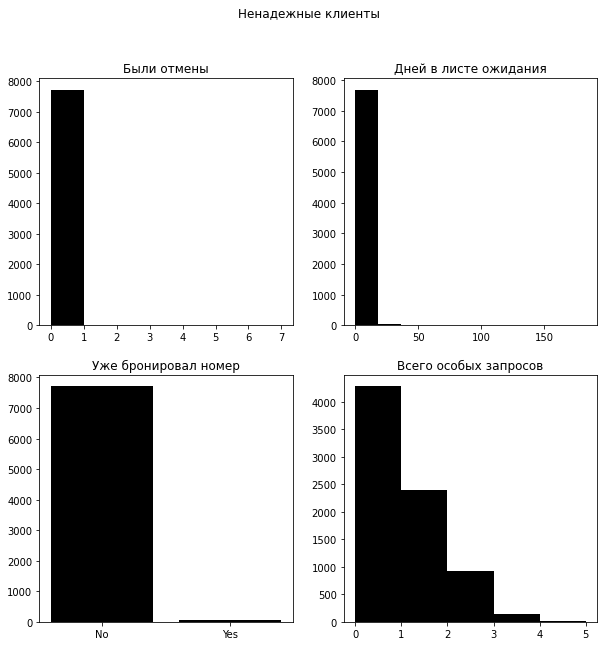

In [375]:
draw_unreliable_clients_diagram(hotel_test)

Исходя из полученных результатов, можно сделать вывод, что ненадежным клиентом является тот, кто ранее уже отменял свои бронирования (<b>previous_cancellations</b>), проводил в ожидании подтверждения (<b>days_in_waiting_list</b>) и имеет низкий уровень лояльности (<b>is_repeated_guest</b>). Также можно сказать, что показатель <b>total_of_special_requests</b> может быть связан с ненадежностью клиента, но это не так очевидно, так как он может быть использован для обоснованных запросов.
<br>
Если смотреть на результаты моделей, то наиболее надежными клиентами будут те, у которых меньше всего отмененных бронирований и меньше всего времени ожидания. Также, надежными могут считаться клиенты, которые являются постоянными гостями, так как они скорее всего имеют повышенный уровень лояльности.

если отель расположен в туристическом районе и привлекает множество семей с детьми, то наличие детей может быть связано с более высокой вероятностью сохранения бронирования, так как эти клиенты могут быть более склонны к планированию своих поездок заранее и более ответственны в своих решениях.
<br>
<br>
с другой стороны, если отель находится в деловом районе и большинство клиентов - это деловые путешественники, то наличие детей может быть связано с более высокой вероятностью отмены бронирования, так как деловым путешественникам могут внезапно измениться планы и им придется отменить свое путешествие.
<br>
<br>
относительно необходимости парковочного места, это может быть важным фактором для клиентов, которые планируют приехать на автомобиле, и отсутствие парковочных мест может быть причиной отмены бронирования. Однако, для тех клиентов, которые не планируют приезжать на автомобиле, отсутствие парковочных мест может быть менее значимым фактором.
<br>
<br>
таким образом, влияние этих признаков на вероятность отмены бронирования может быть контекстуальным и зависеть от многих факторов.

### Шаг 6. Напишите общий вывод

В данном исследовании было проведено обучение трех моделей (логистическая регрессия, дерево решений и случайный лес) с целью предсказания отмены бронирования в отеле. Для обучения моделей использовались следующие признаки: distribution_channel, booking_changes, adults, arrival_date_week_number, has_babies, children, customer_type, country, days_in_waiting_list, is_repeated_guest, lead_time, meal, previous_bookings_not_canceled, previous_cancellations, required_car_parking_spaces, reserved_room_type, total_nights, total_of_special_requests. Категориальные признаки были преобразованы в количественные с помощью метода OneHotEncoder.
<br>
<br>
Были проведены тесты, чтобы оценить точность и работоспособность моделей. получили точности 0,746, 0,742 и 0,760. Наилучшей моделью для прогнозирования отмены бронирования оказалось дерево решений с F1-score 0,368.
<br>
<br>
Определили наиболее важные признаки для оценки надежности клиентов, такие как количество отмененных бронирований, время ожидания и повторное посещение отеля. Клиенты с меньшим числом отмененных бронирований, меньшим временем ожидания и постоянные гости, скорее всего, являются более надежными. Показатель total_of_special_requests также может свидетельствовать о ненадежности клиента, но не так очевидно, так как он может быть использован для обоснованных запросов.
<br>
<br>
Для уменьшения числа отмен бронирований, мы рекомендуем бизнесу ввести систему депозита. Рассчитали потенциальную прибыль отеля без ведения депозита - 34793290.0, и с ведением депозита - 51833380.0. Если бы отель ввел систему депозита, прибыль составляла бы 16640090.0